# Model 2: InceptionV3 with Additional, Augmented Training Image Data
*Adapted from the [Keras Applications](https://keras.io/api/applications/) page and [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification).*  

*This is the second pass model for this project. The details:*
* Built off of the base of the InceptionV3 architecture with pretrained imagenet weights
* Three additional activation layers: a GlobalAveragePooling2D layer, a fully-connected 1,024 neuron relu layer, and a softmax layer to output two classes
* All layers of the InceptionV3 model frozen, thereby permitting training only on the layers added to the base model
* Trained on 75% of the 5,410 images generated in notebook 02 over the course of 8 epochs
* Images in the train and test dataset both normalized to pixel values between 0 and 1 (rather than the original 0 - 255) **and** additional training images created using `ImageDataGenerator`

In [2]:
# import libraries from tensorflow keras (for model building), sklearn (for metrics), matplotlib (for visualization), and np/os/pd (for data processing)
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models, applications, layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Set up the training / testing (75/25) datasets

In [4]:
# create alternate absolute paths for a pre-split training / testing dataset
data_dir_train = os.path.dirname(os.getcwd()) + '\\data\\images-model\\train\\'
data_dir_test = os.path.dirname(os.getcwd()) + '\\data\\images-model\\test\\'

# show the paths created
# print(data_dir)
# print(data_dir_train)
# print(data_dir_test)

In [5]:
# set variables for the model here
# number of images per batch
batch_size = 32

# all images have been resized to 558x558 pixels, the median size of a kithara in the dataset
img_height = 558
img_width = 558

#### Use the 75/25 train/test split from notebook 02 and augment the training dataset
*Note that `shuffle = True` [by default](https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima). Explicitly set `shuffle = False` for the test dataset in order to ensure alignment across the labels and file names (see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)).*  

*In addition, note that the training data generator rescales and randomly generates rotated, shifted up and down, brighter and darker, sheared, zoomed, and horizontally-flipped images, whereas the test generator only rescales the images fed to it.*

In [7]:
# create an image data generator for the training and testing images
train_datagen = image.ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 90,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                brightness_range = [0.5, 1.5],
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [8]:
# create a training and testing dataset from the pre-processed images
# this code uses the train/test split already specified in notebook 02
train_gen = train_datagen.flow_from_directory(
    data_dir_train,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42)

# create a testing dataset from the pre-processed images
test_gen = test_datagen.flow_from_directory(
    data_dir_test,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False, # MUST set this to false to get labels, filepaths, and predictions to align
    seed = 42)

Found 4057 images belonging to 2 classes.
Found 1353 images belonging to 2 classes.


#### Get some identifying information about the files in the test dataset

In [17]:
# get the location of the files in the test dataset
filepaths = test_gen.filenames
# get the labels of the files in the test dataset
test_labels = test_gen.classes
# confirm the order of the 
class_names = test_gen.class_indices

### Build a base model from the inceptionv3 model architecture
*N.B. this is the same base model as in notebook 03a.*

In [15]:
# instantiate the base model, using pretrained weights from imagenet
# note that if this does not run, downgrade h5py
# pip install "h5py==2.10.0" --force-reinstall
base_model = applications.InceptionV3(weights = 'imagenet',
                                      include_top=False,
                                      input_shape = (img_height, img_width, 3))

#### Add customizations to the base model for model

In [16]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and add a logistic layer -- output should be the number of classes (in this case, 2)
predictions = Dense(2, activation='softmax')(x)

In [17]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

#### Compile and review the model

In [19]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['BinaryAccuracy',
                        'FalseNegatives',
                        'FalsePositives',
                        'TrueNegatives',
                        'TruePositives',
                        'AUC',
                        'Precision',
                        'Recall'])

In [20]:
# take a look at the model layer-by-layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 558, 558, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 278, 278, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 278, 278, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 278, 278, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Create checkpoints for the model

In [21]:
checkpoint_path = 'model_checkpoints/training_02/cp-{epoch}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback that saves the model's weights after each training run
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq = 'epoch')

### Fit model on the training data with transformations and normalization

In [22]:
# set the number of passes over the entire dataset as the number of epochs
epochs = 10

# fit the model based on the normalized training data
# write the comparative metrics on the normalized training and testing data to history
history = model.fit(
  train_gen,
  validation_data = test_gen,
  epochs=epochs
)

Epoch 1/10
127/127 [==============================] - 718s 6s/step - loss: 0.2310 - binary_accuracy: 0.9184 - false_negatives: 331.0000 - false_positives: 331.0000 - true_negatives: 3726.0000 - true_positives: 3726.0000 - auc: 0.9700 - precision: 0.9184 - recall: 0.9184 - val_loss: 0.1279 - val_binary_accuracy: 0.9505 - val_false_negatives: 67.0000 - val_false_positives: 67.0000 - val_true_negatives: 1286.0000 - val_true_positives: 1286.0000 - val_auc: 0.9914 - val_precision: 0.9505 - val_recall: 0.9505
Epoch 2/10
127/127 [==============================] - 748s 6s/step - loss: 0.1540 - binary_accuracy: 0.9359 - false_negatives: 260.0000 - false_positives: 260.0000 - true_negatives: 3797.0000 - true_positives: 3797.0000 - auc: 0.9809 - precision: 0.9359 - recall: 0.9359 - val_loss: 0.1000 - val_binary_accuracy: 0.9660 - val_false_negatives: 46.0000 - val_false_positives: 46.0000 - val_true_negatives: 1307.0000 - val_true_positives: 1307.0000 - val_auc: 0.9930 - val_precision: 0.9660 - v

In [23]:
# save the model to utilize later
model.save('saved_models/model-02')

INFO:tensorflow:Assets written to: saved_models/model-02\assets


### Predict the probability that an image contains a chordophone

In [24]:
# predict the probability of kithara / no-kithara label of the normalized_val_ds images
# N.B. COMMENT OUT THIS CELL ONCE IT HAS BEEN RUN TO PREVENT ACCIDENTALLY RE-RUNNING IT
test_predictions = model.predict(test_gen)

In [25]:
# check the min/max probabilities of predicted kithara / no-kithara labels
print(test_predictions.min(axis = 0))
print(test_predictions.max(axis = 0))

# print the names of the classes for clarity
print(class_names)

# return the array of predictions
print(test_predictions)

[9.0586365e-14 3.0048317e-04]
[0.9996996 1.       ]
['kithara', 'no-kithara']
[[8.36971283e-01 1.63028777e-01]
 [9.98934090e-01 1.06587156e-03]
 [4.38370183e-03 9.95616317e-01]
 ...
 [1.12761086e-07 9.99999881e-01]
 [5.77434500e-09 1.00000000e+00]
 [2.01964556e-09 1.00000000e+00]]


#### Convert the probabilities to class predictions
*The cell below converts the array of probabilities into a class prediction for a binary yes/no response to 'is it a kithara?' The probability threshold for determining whether or not an image contains a kithara can be adjusted here.*

In [32]:
# convert the probabilities into a binary class prediction
# adjust the threshold as needed to optimize for precision / recall
# N.B. the threshold is set based on probability of a `no-kithara` label
predicted_class = (test_predictions[:,1]>=0.6).astype(int)
print(predicted_class)

[0 0 1 ... 1 1 1]


### Performance analysis
*Performance analysis for model 2.*

In [27]:
# take a look at the metrics from each epoch
history.history

{'loss': [0.23104248940944672,
  0.15403161942958832,
  0.13750317692756653,
  0.1288987547159195,
  0.12297186255455017,
  0.12134505808353424,
  0.10683605074882507,
  0.11044863611459732,
  0.10931147634983063,
  0.1042705774307251],
 'binary_accuracy': [0.9184126257896423,
  0.9359132647514343,
  0.9420754313468933,
  0.9502094984054565,
  0.9519349336624146,
  0.946265697479248,
  0.9580971002578735,
  0.9529208540916443,
  0.960561990737915,
  0.9600690007209778],
 'false_negatives': [331.0,
  260.0,
  235.0,
  202.0,
  195.0,
  218.0,
  170.0,
  191.0,
  160.0,
  162.0],
 'false_positives': [331.0,
  260.0,
  235.0,
  202.0,
  195.0,
  218.0,
  170.0,
  191.0,
  160.0,
  162.0],
 'true_negatives': [3726.0,
  3797.0,
  3822.0,
  3855.0,
  3862.0,
  3839.0,
  3887.0,
  3866.0,
  3897.0,
  3895.0],
 'true_positives': [3726.0,
  3797.0,
  3822.0,
  3855.0,
  3862.0,
  3839.0,
  3887.0,
  3866.0,
  3897.0,
  3895.0],
 'auc': [0.9699758291244507,
  0.9809064269065857,
  0.983006715774

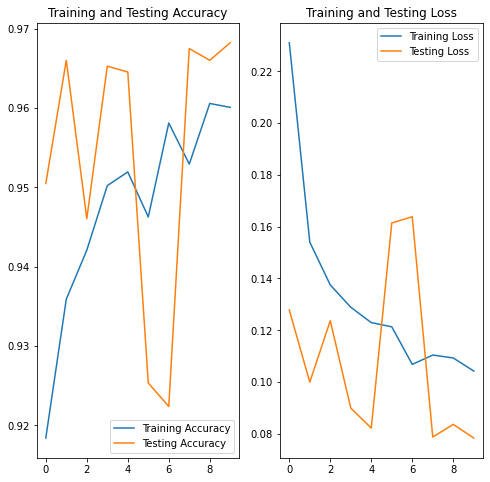

In [28]:
# visualize the model's performance epoch-by-epoch

# set accuracy variables
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# set loss variables
loss = history.history['loss']
val_loss = history.history['val_loss']

# set epoch range
epochs_range = range(epochs)

# plot accuracy for training vs. testing dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

# plot loss for training vs. testing dataset
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [33]:
# print the accuracy of the kithara identification compared to the predicted class with the threshold set above
print(accuracy_score(test_labels, predicted_class))

# print the AUC for the model
print(roc_auc_score(test_labels, test_predictions[:,1]))

# print the overall classification report with precision, recall, accuracy, and f1-scores
print(classification_report(test_labels, predicted_class, target_names = class_names))

0.9667405764966741
0.9884893203883496
              precision    recall  f1-score   support

     kithara       0.73      0.89      0.80       103
  no-kithara       0.99      0.97      0.98      1250

    accuracy                           0.97      1353
   macro avg       0.86      0.93      0.89      1353
weighted avg       0.97      0.97      0.97      1353



In [35]:
##### create a dataframe to hold the filenames, actual values, and predicted no-kithara probability
pred_df = pd.DataFrame({'filepath': filepaths, 'actuals': test_labels, 'predictions': test_predictions[:,0]})

# take a look at the dataframe where the known value was a kithara
pred_df[pred_df['actuals'] == 0].sort_values('predictions')

,filepath,actuals,predictions
6,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG0077-kithara-full.jpg,0,0.003342
2,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG0045-kithara-full.jpg,0,0.004384
92,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG9864b-kithara-full.jpg,0,0.004907
96,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG9870a-kithara-full.jpg,0,0.023544
36,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG1542-kithara-full.jpg,0,0.064459
74,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG8619-kithara-full.jpg,0,0.065085
10,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG0157-kithara-full.jpg,0,0.072118
28,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG0952a-kithara-full.jpg,0,0.096838
20,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG0366-kithara-full.jpg,0,0.101987
75,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test\kithara\IMAG8804b-kithara-full.jpg,0,0.124684


In [ ]:
# # check to see if specific images are included in the training dataset
# pred_df[pred_df['filepath'].str.contains('IMAG9081')]